## TPC3 - Rafael Machado Salgueiro

In [7]:
#imports
from numpy import *
import matplotlib.pyplot as plt
import numpy as np

Pretendemos simular a propagação de ondas sísmicas, na situação simplificada de 1D. A equação de propagação da componente $y$ do deslocamento, $u_y(x,t)$, num meio com densidade $\rho(x)$ e constante elástica $\mu(x)$ é:
$$\rho(x) \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial}{\partial x} \bigg( \mu(x) \frac{\partial u_y}{\partial x}\bigg) + f_y,$$

onde $f_y(x,t)$ é uma força exteriormente aplicada (algo que dá origem a um sismo, como um deslocamento de placas, ou um desmoronamento sub-aquático). Use um método pseudo-espectral à sua escolha. Deve referir a razão da escolha, comparando com outro(s).
Para a força, use a função `ricke`, que se encontra no Moodle, com $f_0$ como frequência central. Como parâmetros use:

| Stretch/Untouched | ProbDistribution |
| :- | :-: |
| $\rho$ | $2500\ kg m^{-3}$ |
| $\mu$  | $2.25 \times 10^{10} kg  m^{-1}s^{-2}$ |
| $f_0$  | $100\ kHz$ |

Como é evidente, deve re-escalar a equação.

Considere condições fronteira de Dirichelet.

Deve submeter, além do código, um pequeno filme, ou conjunto de plots sequenciais, da evolução da perturbação inicial para o caso da alínea (e). Em cada imagem (plot) deve mostrar o tempo e indicar as quantidades representadas.

Cada um deve apresentar apenas trabalho seu. Podem usar as rotinas que coloquei no Moodle, ou outras equivalentes que tenham desenvolvido, mesmo que baseados nalguma fonte (mas devem claramente identificar essa fonte(s)).

a) Escolha um esquema para descretizar a derivada temporal, indicando também que método pretende usar para a evolução temporal. Discuta as vantagens e desvantagens desse método.

Vamos dividir o domínio temporal em $N_t+1$ instantes, de modo que:

$$
t_i = n\Delta t,\ n=0,\ldots,N_t.
$$

Com esta descretização a equação acima mencionada fica da seguinte forma:

$$
\rho_{i} \frac{u_{i}^{n+1}-2 u_{i}^{n}+u_{i}^{n-1}}{d t^{2}}=\partial_{x}\left(\mu(x) \partial_{x} u(x, t)\right)_{i}^{n}+f_{i}^{n}
$$

onde se escolheu as diferenças centrais para a segunda derivada no tempo.

Para a evolução temporal desta equação irei usar o método explícito. Uma desvantagem do método explícito é este não ser incondicionalmente estável. O método explícito é apenas estável para números de Courante iguais ou inferiores a 1.

b) Use a rotina `ricker` (ler com cuidado a sua descrição, em particular os argumentos que pede e o respectivo uso, bem como a forma do resultado), de modo a gerar o termo fonte à frequência pretendida.

A força externa irá atuar apenas num dado ponto do espaço. A função ricker dá os diferentes valores da força nos diferentes instantes de tempo espaçados de dt. A partir da frequência $f_{0}$ determina-se o período (pt) a colocar como argumento nesta função.

Neste problema será útil medir o tempo em unidades de $T_0 = \frac{1}{f_0} = 1 \times 10^{-5} $ s, pelo que o valor de pt a introduzir na função ricker será sempre igual a 1. Desta forma o valor de $\mu_0$ passará a ser 2.25 $kgm^{-1}$.

De referir também que esta força apenas atua durante o período $T_0$ de forma a haver apenas uma perturbação e não várais, apesar de também se puder fazer essa simulação.

200


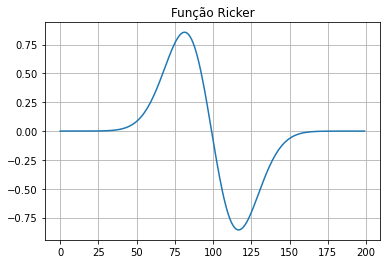

In [8]:
def ricker(dt, pt):
    """
    RICKER generate a ricker wavelet
    input (dt,pt)
    """
    nt = int(2 * pt / dt)
    c = np.zeros(nt)
    t0 = pt / dt
    a_ricker = 4 / pt

    for it in range(0, nt):
        t = ((it + 1) - t0) * dt
        c[it] = -2 * a_ricker * t * exp(-(a_ricker * t) ** 2)

    return c

# Visualização da função ricker
y = ricker(10/200,5)
print(len(y))

plt.title("Função Ricker")
plt.plot(y)
plt.grid()
plt.show()

c) Use um método espectral à sua escolha para discretizar as derivadas espaciais. Discuta os méritos e deméritos do método escolhido. Implemente um código que realize esta discretização.

Para descretizar as derivadas espaciais irei usar o método pseudo-espectral de Chebychev, pelo que a equação de onda fica da seguinte forma:

$$\rho_i  \frac{ u_i^{n+1} - 2u_i^{n}+u_i^{n-1}}{ dt^2} = \boldsymbol{D} (\boldsymbol{\mu} \odot \boldsymbol{D} \boldsymbol{u}^{n}) + {f_i}^{n}$$

onde $\boldsymbol{D}$ representa a matriz de diferenciação de Chebyshev e o símbolo $\odot$ representa a multiplicação elemento a elemento.

Reescrevendo esta equação em ordem ao único elemento desconhecido ($u_i^{n+1}$) temos:

$$ u_i^{n+1} = \frac{dt^2}{\rho_i} \left( \boldsymbol{D} (\boldsymbol{\mu} \odot \boldsymbol{D} \boldsymbol{u}^{n}) + {f_i}^{n} \right) + 2u_i^{n} - u_i^{n-1}
$$

Apenas há que ter em atenção que no primeiro passo irá haver uma variável desconhecida que é $u_i^{n-1}$ o que impediria o começo do algoritmo. Para resolver este problema temos de recorrer às condições iniciais (CI):

$$
u(x,0) = 0 \\
\frac{\partial}{\partial t}u(x,0) = 0,
$$

Estas duas condições iniciais garantem que antes de ocorrer a perturbação no meio os deslocamentos são nulos e as velocidades nulas como é de esperar. A segunda CI permite obter o seguinte resultado:

$$ u_t=0 \Rightarrow \frac{u_i^{n+1}-u_i^{n-1}}{2\Delta t} = 0 \Rightarrow u_i^{n+1}=u_i^{n-1}$$

Assim o primeiro passo do algoritmo será :

$$ u_i^{n+1} = \frac{dt^2}{2\rho_i} \left( \boldsymbol{D} (\boldsymbol{\mu} \odot \boldsymbol{D} \boldsymbol{u}^{n}) + {f_i}^{n} \right) + u_i^{n}
$$

De referir também que na resolução desta equação serão usados condições de de fronteira (CF) de Dirichelet pelo que u toma sempre o valor zero nas fronteiras.

Uma das desvantagens do uso do método de Chebyshev é o facto de o número de pontos de descretização nas fronteiras ser muito superior em relação à parte intermédia do domínio. Uma vantagem é a sua fácil aplicação.

In [9]:
def cheb(N):
    if N==0:
        D = 0.; x = 1.
    else:
        n = arange(0,N+1)
        x = cos(pi*n/N).reshape(N+1,1)
        c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = tile(x,(1,N+1))
        dX = X - X.T
        D = dot(c,1./c.T)/(dX+eye(N+1))
        D -= diag(sum(D.T,axis=0))
    return D, x.reshape(N+1)

d) Escreva o código que lhe permite evoluir o pacote de ondas no tempo com os ingredientes obtidos nas alíneas anteriores. Teste com os parâmetros da tabela acima, que correspondem a um meio homogéneo (logo, sabe a velocidade de propagação, que é constante em todo o domínio!)

In [13]:
def rho_constante(x,a):
    return np.full(len(x),2500)

def miu_constante(x,a):
    return np.full(len(x),2.25)

def onda_sismica_1D(func_rho,func_miu,T,Nx,f,pt,a):
    """
    func_rho - função que cria os valores da densidade do meio segundo x
    func_miu - função que cria os valores da constante elástica segundo x
    T - tempo final
    Nx+1 - número de nodos na grelha espacial, nodos esses que serão calculados pelo método cheb
    f - função que calcula a força exterior aplicada (neste caso será sempre a ricker)
    pt - período (parâmetro a introduzir na função ricker)
    
    """
    
    D,x = cheb(Nx)
    
    rho = func_rho(x,a)
    miu = func_miu(x,a)
    
    # Determinação de dt de forma a evitar problemas de convergência do método explícito
    # C - numero de Courant tem de ser menor ou igual a 1
    # C = c*dt/dx onde c é a velocidade do meio
    
    delta_x = abs(np.diff(x))  # array de valores de delta_x
    delta_x_min = min(delta_x)
    
    c_max = np.sqrt(max(miu)/min(rho))
    
    dt = (0.95*delta_x_min)/c_max
    print(dt)
    
    print(c_max*dt/delta_x_min)
    
    # Força exteriormente aplicada durante um período pt
    force = f(dt,pt)
    
    # Após esse período a força aplicada deixa de existir
    forca = np.full(int(T/pt)*len(force),0.0)
    forca[0:len(force)] = force
    Nt = len(forca)
    
    print(Nt)
    
    #plt.plot(forca)
    #plt.show()
    
    u    = np.zeros(len(x))  # futuro
    u_1  = u.copy()          # presente
    u_2  = u.copy()          # passado

    # Condição inicial encontra-se já imposta u(x,0) = 0

    # Aplicar a fórmula especial no primeiro passo, com du/dt=0 incorporada
    index_forca = 10 # local onde atua a força
    aux = D@(miu*(D@u_1.T))
    u[:] = (dt**2/(2*rho))*(aux)+u_1
    u[index_forca] = (dt**2/(2*rho[index_forca]))*(aux[index_forca]+forca[0])+u_1[index_forca]
        
    # Impôr condições fronteira (Dirichelet)
    u[0] = 0  
    u[Nx] = 0

    # Trocar papel das variáveis antes do próximo passo (presente passa a passado, futuro passa 
    # a presente)
    u_2[:], u_1[:] = u_1, u

    for n in range(1, Nt):
        
        # Actualizar todos os nodos no instante t[n+1]
        aux_1 = D@(miu*(D@u_1.T))
        u[:] = (dt**2/(rho))*(aux_1) + 2*u_1 - u_2
        u[index_forca]=(dt**2/(rho[index_forca]))*(aux_1[index_forca]+forca[n])+2*u_1[index_forca]-u_2[index_forca]
                                      
        # Aplicar condições fronteira
        u[0] = 0  
        u[Nx] = 0

        # Trocar papel das variáveis antes do próximo passo
        u_2[:], u_1[:] = u_1, u
        
        if n%1000 == 0:
            plt.title("Onda sísmica em 1D: t={:.3f}".format(n*dt),fontsize=16,pad=10)
            plt.grid()
            plt.plot(x, u)
            plt.xlabel("x",fontsize=12,labelpad=10)
            plt.ylabel("u",fontsize=12,labelpad=10)
            plt.ylim(-2e-7,2e-7)
            plt.savefig(f'images_1-{n}.png',dpi=100,facecolor="white")
            #plt.legend()
            plt.close()
            #plt.show()

onda_sismica_1D(rho_constante,miu_constante,80,600,ricker,1,1)
#onda_sismica_1D(func_rho,func_miu,T,Nx,f,pt,a)

0.0004340788314864212
0.95
368560


In [19]:
# Criar gif
import imageio
Nt = 368560

with imageio.get_writer("Sismo_homogeneo.gif",mode="i") as writer:
    for n in range(1000,368560,1000):
        image = imageio.imread(f'images_1-{n}.png')
        writer.append_data(image)

e) Simule a situação de um meio não homogéneo. Considere que as funções $\rho, \mu$ dependem de $x$, variando numa região estreita, de um valor $p_{\textrm{min}}=p_0$ a outro $p_{\textrm{min}}=p_0 + \Delta p \equiv p_1.$ Tome, por exemplo,:
$\rho(x) = (\rho_0 + \rho_1e^{ax})/(1 + e^{ax}),$
onde $a$ é uma constante  positiva, suficientemente grande para fazer que a variação ocorra num intervalo de $5\%$ do seu domínio.(Considere uma expressão semelhante para $\mu$.) Tome $\Delta \rho/ \rho= 0.50$ e $\Delta \mu/ \mu= 0.05.$

As funções $\rho(x)$ e $\mu(x)$ encontram-se ilustradas nos gráficos a seguir. Nestes é possível ver a existência de dois regimes e também conclui-se que quanto maior for o valor de $a$ mais abrupta será a variação dos valores de $\rho$ e $\mu$. Sabendo que a variação deve ser o mais abrupta possível escolhi o valor de 100 para $a$.

A velocidade de propagação da onda ($c$) é dada pela seguinte equação:

$$
c = \sqrt{\frac{\mu}{\rho}}
$$

Esta equação permite-nos estimar as velocidades de propagação da onda:

$$ 
[0,1] : c  \approx 7,0 \times 10^{-4} m/s \\
[-1,0] : c  \approx 1,0 \times 10^{-3} m/s
$$

É portanto de esperar que à passagem na origem a velocidade de propagação da onda se altere. Os resultados confirmam esta previsão.

Numa outra experiência aumentei o valor de $a$ para 600 de forma a tentar observar uma reflexão devido a uma variação muito brusca da velocidade. Essa observação foi visível apesar de reduzida. Não foi possível aumentar aumentar mais o $a$ devido a erros de overflow nas expressões do $\rho$ e do $\mu$.

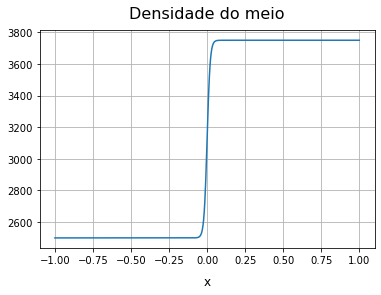

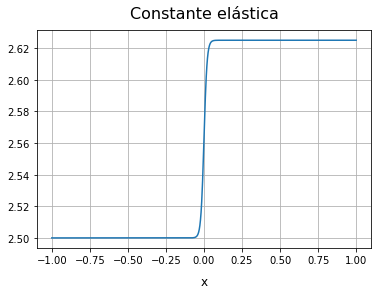

In [20]:
def rho_not_constante(x,a):
    rho_0 = 2500
    rho_1 = rho_0 + 0.5*rho_0
    num = (rho_0+rho_1*np.exp(a*x))
    den = 1+np.exp(a*x)
    
    return num/den

XX = np.linspace(-1,1,1000)

plt.plot(XX,rho_not_constante(XX,100))
plt.title("Densidade do meio",fontsize=16,pad=12)
plt.xlabel("x",fontsize=12,labelpad=10)
plt.grid()
plt.show()

def miu_not_constante(x,a):
    miu_0 = 2.5
    miu_1 = miu_0 + 0.05*miu_0
    num = (miu_0+miu_1*np.exp(a*x))
    den = 1+np.exp(a*x)
    
    return num/den

XX = np.linspace(-1,1,1000)

plt.plot(XX,miu_not_constante(XX,100))
plt.title("Constante elástica",fontsize=16,pad=12)
plt.xlabel("x",fontsize=12,labelpad=10)
plt.grid()
plt.show()

In [21]:
onda_sismica_1D(rho_not_constante,miu_not_constante,80,600,ricker,1,100)

0.00040187890707591096
0.95
398080


In [22]:
# Criar gif
import imageio
Nt = 368560

with imageio.get_writer("Sismo_nao_homogeneo.gif",mode="i") as writer:
    for n in range(1000,368560,1000):
        image = imageio.imread(f'images_1-{n}.png')
        writer.append_data(image)

In [36]:
onda_sismica_1D(rho_not_constante,miu_not_constante,80,600,ricker,1,600)

0.00040187890707591096
0.95
398080


In [29]:
# Criar gif
import imageio
Nt = 368560

with imageio.get_writer("Sismo_nao_homogeneo_a_600.gif",mode="i") as writer:
    for n in range(1000,368560,1000):
        image = imageio.imread(f'images_1-{n}.png')
        writer.append_data(image)